In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sktime.utils import plotting
from sktime.forecasting.model_selection import temporal_train_test_split

from src.sanity import *

from src.load_datasets import load_air_polution_data

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [3]:
dataframe = (
    load_air_polution_data()
    .pipe(format_datetime, col="date")
    .pipe(set_index, col="date")
    .pipe(interpolate_column, cols="pollution")
    .pipe(resample_data, freq="H")
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (43800, 9)
set_index: DF Shape (43800, 8)
interpolate_columns: DF Shape (43800, 8)
resample_Data: DF Shape (43800, 7)
dataframe shape (43800, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  43800 non-null  float64
 1   dewp       43800 non-null  float64
 2   temp       43800 non-null  float64
 3   press      43800 non-null  float64
 4   wnd_spd    43800 non-null  float64
 5   snow       43800 non-null  float64
 6   rain       43800 non-null  float64
dtypes: float64(7)
memory usage: 2.7 MB
None


,pollution,dewp,temp,press,wnd_spd,snow,rain
date,,,,,,,
2010-01-02 00:00:00,129.0,-16.0,-4.0,1020.0,1.79,0.0,0.0
2010-01-02 01:00:00,148.0,-15.0,-4.0,1020.0,2.68,0.0,0.0
2010-01-02 02:00:00,159.0,-11.0,-5.0,1021.0,3.57,0.0,0.0
2010-01-02 03:00:00,181.0,-7.0,-5.0,1022.0,5.36,1.0,0.0
2010-01-02 04:00:00,138.0,-7.0,-5.0,1022.0,6.25,2.0,0.0


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

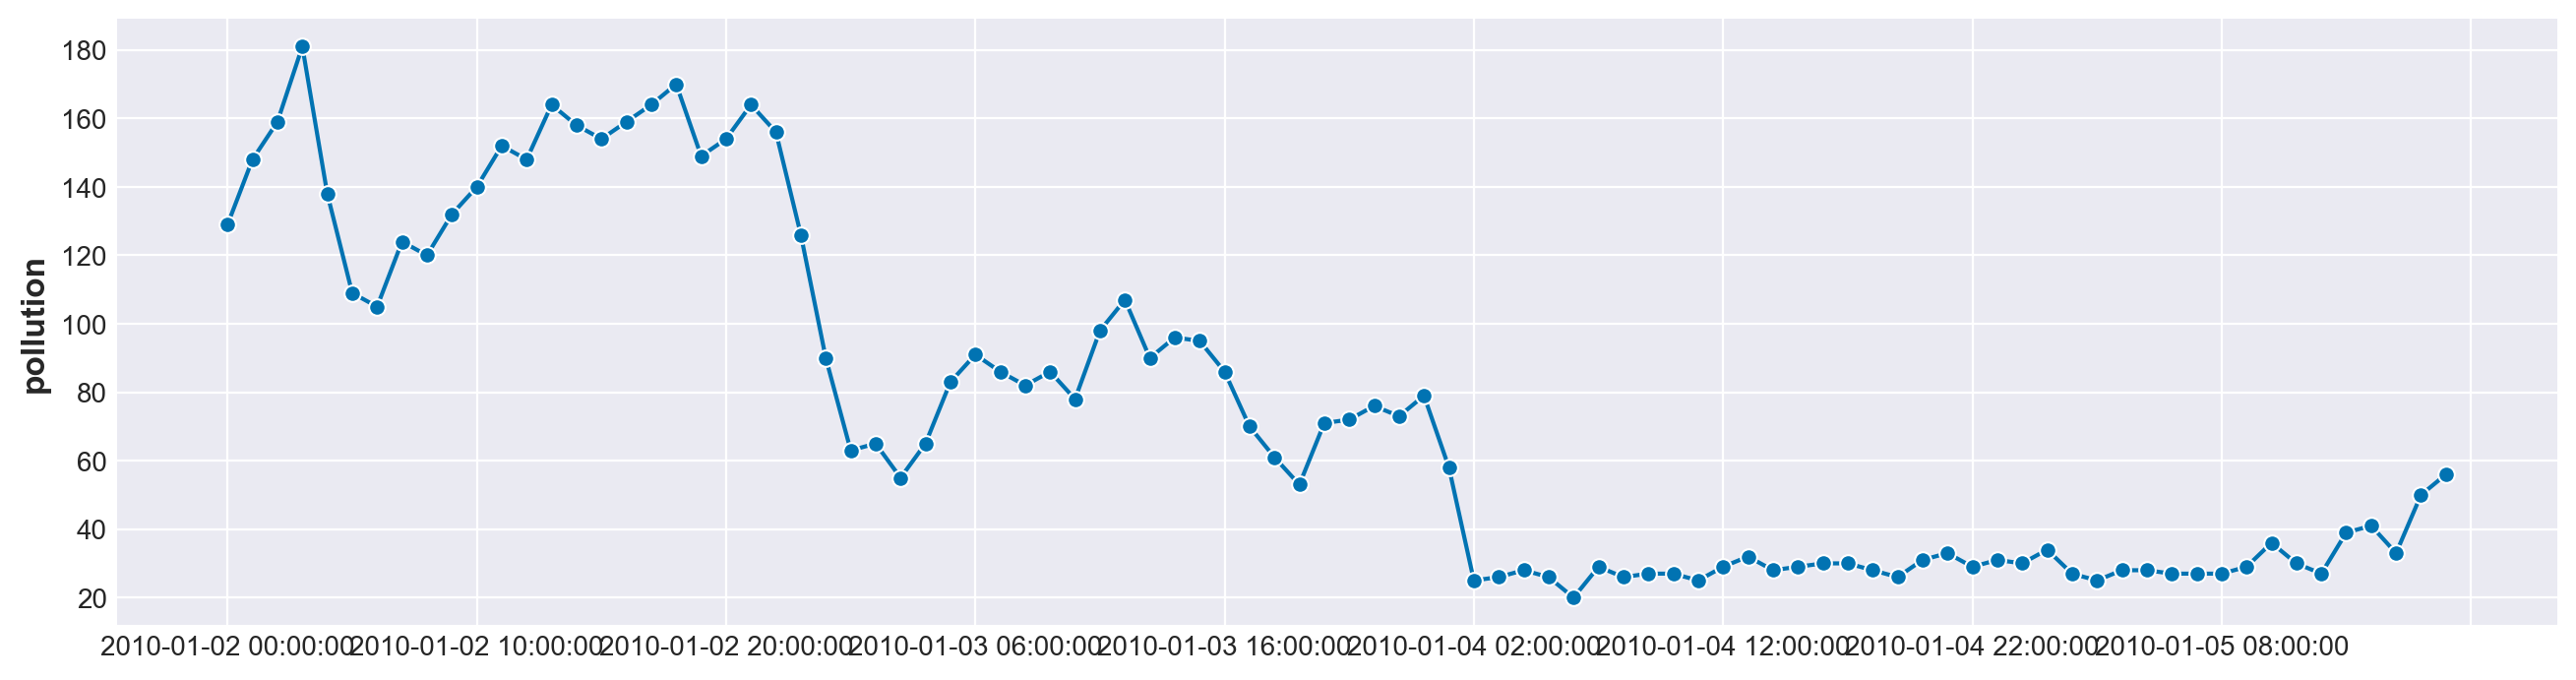

In [4]:
plotting.plot_series(dataframe["pollution"][:90])

### KNeighborsRegressor

In [ ]:
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.compose.ForecastingPipeline

model_name = "KNeighborsRegressor"

estimator_ = ForecastingPipeline(
    [
        ("scaler", StandardScaler()),
        "forecast",
                    make_reduction(
                        estimator=self.regressor,
                        scitype="tabular-regressor",
                        transformers=self.fe_target_rr,
                        window_length=None,
                        strategy="recursive",
                        pooling="global",
                    ),
    ]
)

param_grid = {"regressor__n_neighbors": [5, 7, 12, 15, 20, 25, 30]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y)

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y, yhat)
predictionsDF[model_name] = yhat[:, 0]

In [ ]:
show_series(
    [train_y[target_column][-90:], test_y[target_column], predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [ ]:
from sklearn.linear_model import BayesianRidge
from sklearn.multioutput import MultiOutputRegressor

model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            MultiOutputRegressor(
                BayesianRidge(fit_intercept=True, verbose=True, compute_score=True)
            ),
        ),
    ]
)


model.fit(train_x, train_y)
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y, yhat)
predictionsDF[model_name] = yhat[:, 0]

In [ ]:
show_series(
    [train_y[target_column][-90:], test_y[target_column], predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [ ]:
from sklearn.linear_model import LassoCV, MultiTaskLassoCV
from sklearn.model_selection import TimeSeriesSplit

model, yhat, model_name = None, None, None

model_name = "LassoCV"

cross_validator = TimeSeriesSplit(n_splits=3)

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            MultiTaskLassoCV(
                fit_intercept=True,
                cv=cross_validator,
                random_state=80,
                max_iter=5000,
                verbose=True,
            ),
        ),
    ]
)

model.fit(train_x, train_y)
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y, yhat)
predictionsDF[model_name] = yhat[:, 0]

In [ ]:
show_series(
    [train_y[target_column][-90:], test_y[target_column], predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

# Best Params {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500}

param_grid = {
    #'bootstrap': [True,False],
    # "max_depth": [7, 8, 9],
    # "min_samples_leaf": [2, 3],
    # "min_samples_split": [7, 8],
    # "n_estimators": [300, 500, 600],
    "max_depth": [9],
    "min_samples_leaf": [2],
    "min_samples_split": [7],
    "n_estimators": [500],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())


gsearch.fit(train_x, train_y)

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y, yhat)
predictionsDF[model_name] = yhat[:, 0]

In [ ]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

In [ ]:
import xgboost as xgb

model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y, yhat)

predictionsDF[model_name] = yhat[:, 0]

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

In [ ]:
show_series(
    [train_y[target_column][-90:], test_y[target_column], predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [ ]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 10000,
}

model = MultiOutputRegressor(LGBMRegressor(random_state=80))

model.fit(
    train_x,
    train_y.to_numpy(),
    # eval_set=[(train_x, train_y), (test_x, test_y)],
    # eval_metric="mae",
    # callbacks=[early_stopping(stopping_rounds=5000),
    #           log_evaluation()],
)


# yhat = model.predict(test_x, num_iteration=model.best_iteration_)
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y, yhat)

predictionsDF[model_name] = yhat[:, 0]

In [ ]:
show_series(
    [train_y[target_column][-90:], test_y[target_column], predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [ ]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(
    loss_function="MultiRMSE",
    eval_metric="MultiRMSE",
    learning_rate=0.1,
    depth=4,
    iterations=1000,
)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=False
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y, yhat)

predictionsDF[model_name] = yhat[:, 0]

In [ ]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [ ]:
print(grid_search_results["params"])

In [ ]:
del (
    train_data,
    test_data,
    train_data_feat,
    test_data_feat,
    train_x,
    train_y,
    test_x,
    test_y,
    train_pool,
    test_pool,
)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model, yhat, model_name = None, None, None

model_name = "LSTM_Dense"

WINDOW_LEN = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100
EPOCHS_ = 15

train_data, test_data = test_train_split(dataframe, test_size=WINDOW_LEN + 30)

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)


def window_data(X_data, y_data, window_len=7):
    x_, y_ = [], []
    for i in range(window_len - 1, len(X_data)):
        x_.append(X_data[i - window_len + 1 : i + 1])
        y_.append(y_data[i])
    return np.array(x_), np.array(y_)


train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)

train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

x_window = np.concatenate([train_x, test_x])
y_window = np.concatenate([train_y, test_y])


x_window, y_window = window_data(x_window, y_window, window_len=WINDOW_LEN)

x_train_data, x_test_data = x_window[: -len(test_x)], x_window[-len(test_x) :]
y_train_data, y_test_data = y_window[: -len(test_x)], y_window[-len(test_x) :]

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
)


test_data = (
    tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))
    .batch(BATCH_SIZE)
    .repeat()
)

model = tf.keras.models.Sequential(
    [
        LSTM(128, input_shape=x_window.shape[-2:], dropout=0.0),
        Dense(128),
        Dense(128),
        Dense(1),
    ]
)

model.compile(optimizer="rmsprop", loss="mse", metrics="mae")

training_history = model.fit(
    train_data,
    epochs=EPOCHS_,
    steps_per_epoch=200,
    validation_data=test_data,
    validation_steps=50,
)
yhat = model.predict(x_test_data)
print(yhat.shape)

In [ ]:
resultsDict[model_name] = evaluate(y_test_data.flatten(), yhat.flatten())

predictionsDF[model_name] = yhat.flatten()[-len(predictionsDF.index) :]

In [ ]:
plot_tf_training_history(training_history)

In [ ]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [ ]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

In [ ]:
resultsDF.T

In [ ]:
plot_metrics(resultsDF)

In [ ]:
resultsDF_T = resultsDF.T.copy(deep=True)

resultsDF_T["Dataset"] = "Air_Polution"
resultsDF_T["Mode"] = "Singel_step"

result_path = "./results/results.csv"


if os.path.isfile(result_path) is False:
    resultsDF_T.to_csv(result_path, index=False)
else:
    result_data = pd.read_csv(result_path)
    if result_data[result_data["Dataset"] == "Air_Polution"].shape[0] > 0:
        result_data = result_data[result_data["Dataset"] != "Air_Polution"].copy()

    new_data = pd.concat([result_data, resultsDF_T])
    new_data.to_csv(result_path, index=False)